## Prevendo os preços do Petróleo Brent do IPEA

Neste documento relatamos os modelos preditivos do Petróleo Brent seguindo a base de dados do IPEA, prevendo diariamente os preço em dólares da base de dados

Para isso, vamos utilizar a base de dados com os valores do Petróleo Brent a partir de 1987 até os dias atuais, selecionando este período para ter uma grande quantidade de dados para treinamento e teste do modelo para dados diários.

Por meio da coleta e análise dos dados, vamos avaliar a evolução dos preços do Petróleo ao longo do tempo e entender se é possível prever com a acuricidade desejada os preços no período estipulado.

#### **Problema de negócio:**

Como objetivo pretendemos demonstrar para a empresa do setor de Petróleo e Gás o fluxograma de obtenção, tratamento e carga dos dados, treinamento, modelagem e deploy do modelo de machine learning para predição dos dados e um dashboard com insights acerca dos dados.

#### **Desafio**

Precisamos testar diversas técnicas de machine learning para gerar um modelo que atinja uma boa acurácia para usarmos no deploy de nossa aplicação.

In [7]:
import pandas as pd
from plotly import graph_objs as go
from utils import atualizando_dados_ipea

In [8]:
path = atualizando_dados_ipea()
dados = pd.read_csv(path)

In [21]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11092 entries, 0 to 11091
Data columns (total 2 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Data                                  11092 non-null  datetime64[ns]
 1   Preço - petróleo bruto - Brent (FOB)  11092 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 173.4 KB


In [20]:
dados["Data"] = pd.to_datetime(dados["Data"], format="%Y-%m-%d")

In [22]:
dados.tail()


,Data,Preço - petróleo bruto - Brent (FOB)
11087,2024-01-16,80.15
11088,2024-01-17,78.88
11089,2024-01-18,81.04
11090,2024-01-19,80.71
11091,2024-01-22,81.70


In [23]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=dados['Data'], y=dados['Preço - petróleo bruto - Brent (FOB)'], name="Preço do Petróleo Brent"))
fig.layout.update(title_text='Preço do Petróleo Brent (FOB)', xaxis_rangeslider_visible=True)
fig.show()   

### Métricas

In [62]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
import math

def wmape(y_true, y_pred):
  return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()

### Arima

In [87]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

Primeiro, vamos realizar um resample dos dados, mantendo o período diário e passando para as datas que não possuem os valores (sábados, domingos e feriados) o mesmo valor do dia anterior (ffill)

In [53]:
dados_resample = dados.set_index("Data").resample('1D').ffill()
dados_resample

,Preço - petróleo bruto - Brent (FOB)
Data,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-23,18.55
1987-05-24,18.55
...,...
2024-01-18,81.04
2024-01-19,80.71
2024-01-20,80.71


<Figure size 800x600 with 0 Axes>

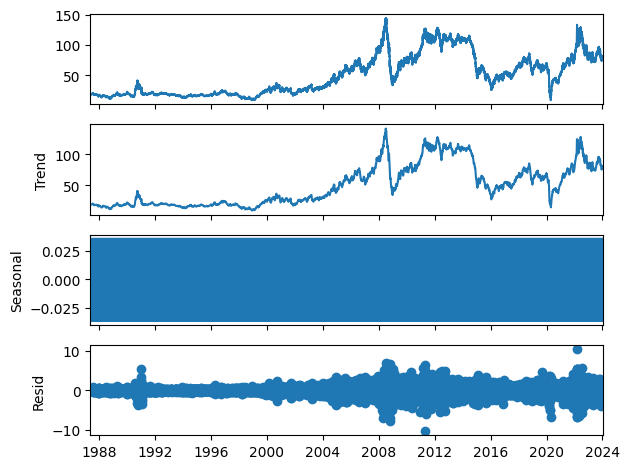

In [81]:
resultado = seasonal_decompose(dados_resample)

fig = plt.figure(figsize=(8,6))
fig = resultado.plot()

##### Teste de estacionariedade

In [82]:
from statsmodels.tsa.stattools import adfuller

testADF = adfuller(dados["Preço - petróleo bruto - Brent (FOB)"])

In [83]:
print("Dickey-Fuller Aumentado")
print('Teste Estatístico: {:.4f}'.format(testADF[0]))
print('Valor-p: {:.4f}'.format(testADF[1]))
print('Valores Críticos:')
for key, value in testADF[4].items():
	print('\t{}: {:.4f}'.format(key, value))

Dickey-Fuller Aumentado
Teste Estatístico: -2.0728
Valor-p: 0.2556
Valores Críticos:
	1%: -3.4309
	5%: -2.8618
	10%: -2.5669


In [85]:
testADF = adfuller(dados["Preço - petróleo bruto - Brent (FOB)"].diff().dropna())
print("Dickey-Fuller Aumentado")
print('Teste Estatístico: {:.4f}'.format(testADF[0]))
print('Valor-p: {:.4f}'.format(testADF[1]))
print('Valores Críticos:')
for key, value in testADF[4].items():
	print('\t{}: {:.4f}'.format(key, value))

Dickey-Fuller Aumentado
Teste Estatístico: -17.1677
Valor-p: 0.0000
Valores Críticos:
	1%: -3.4309
	5%: -2.8618
	10%: -2.5669


In [54]:
train_ARIMA = dados_resample[:'2014-12-31']
test_ARIMA = dados_resample['2015-01-01':]

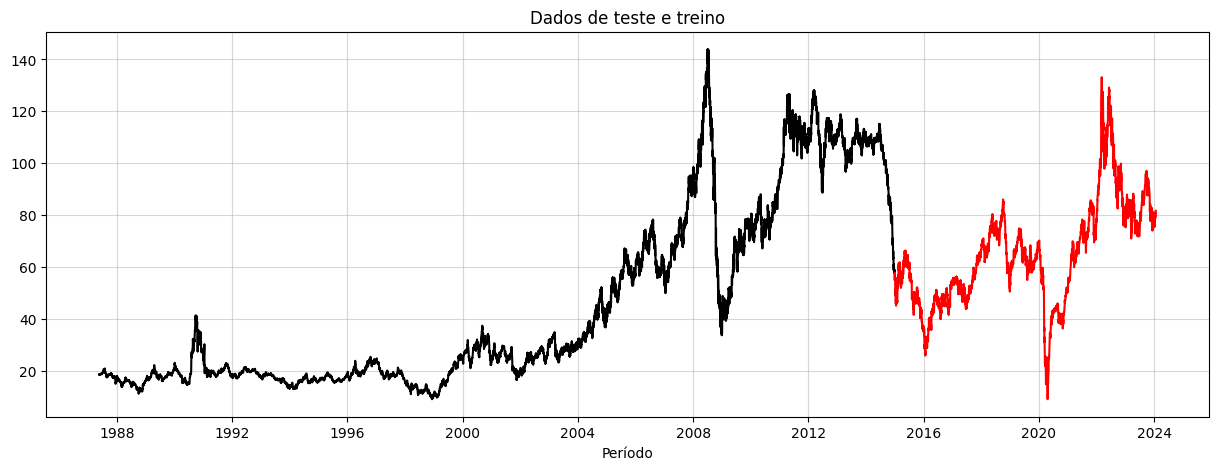

In [47]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(train_ARIMA, 'black', test_ARIMA, 'red')
plt.title("Dados de teste e treino")
plt.xlabel('Período')
plt.grid(alpha=0.5)
plt.show()

In [55]:
print(f'Qtd de dados de treino: {train_ARIMA.shape[0]} \n\nQtd de dados de teste: {test_ARIMA.shape[0]}')

Qtd de dados de treino: 10088 

Qtd de dados de teste: 3309


In [69]:
model_arima = ARIMA(train_ARIMA, order =(1,1,1))
arima_fit = model_arima.fit()
print(arima_fit.summary())

                                        SARIMAX Results                                         
Dep. Variable:     Preço - petróleo bruto - Brent (FOB)   No. Observations:                10088
Model:                                   ARIMA(1, 1, 1)   Log Likelihood              -16279.648
Date:                                  Sat, 27 Jan 2024   AIC                          32565.296
Time:                                          17:05:46   BIC                          32586.953
Sample:                                      05-20-1987   HQIC                         32572.623
                                           - 12-31-2014                                         
Covariance Type:                                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2843      0.017     16.751      0.000       0.251

In [70]:
pred_ARIMA = arima_fit.predict(train_ARIMA.shape[0], dados_resample.shape[0]-1, dynamic=True)
pred_ARIMA.shape

(3309,)

In [71]:
wmape(test_ARIMA.values,pred_ARIMA.values)

847.9523081633677

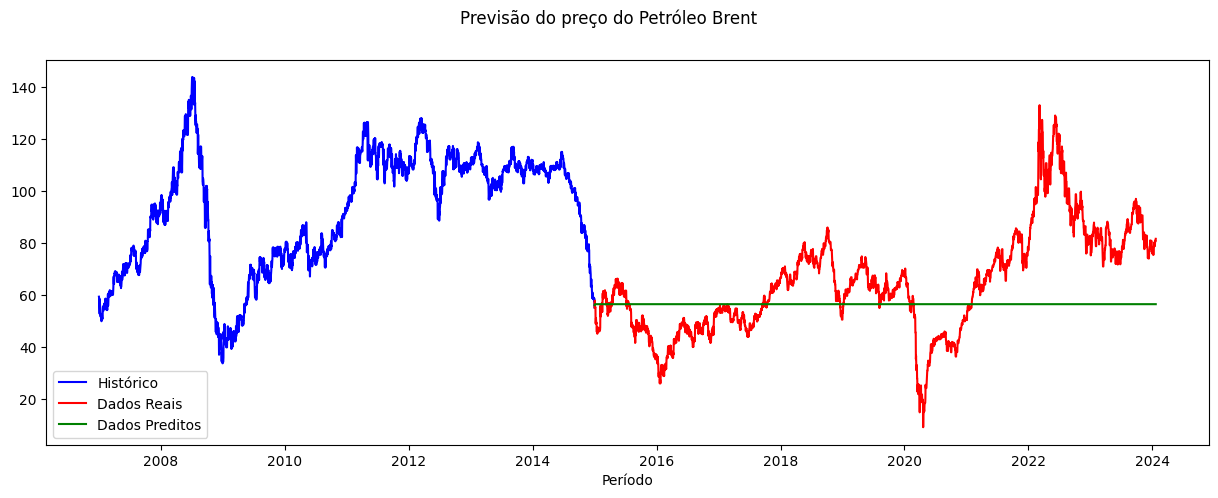

In [72]:
fig, ax = plt.subplots(figsize = (15,5))
fig.suptitle('Previsão do preço do Petróleo Brent')

dados_treinoA, = plt.plot(train_ARIMA.loc['2007-01-01':],"b", label = "Histórico")
dados_testeA, = plt.plot(test_ARIMA, "r", label = "Dados Reais")
dados_predA, = plt.plot(pred_ARIMA, "g", label = "Dados Preditos")
plt.legend(handles=[dados_treinoA, dados_testeA, dados_predA])
plt.xlabel('Período')
plt.show()

In [73]:
mae_arimam = mean_absolute_error(test_ARIMA.values, pred_ARIMA.values)
mse_arimam = mean_squared_error(test_ARIMA.values, pred_ARIMA.values)
rmse_arimam = math.sqrt(mse_arimam)
mape_arimam = mean_absolute_percentage_error(test_ARIMA.values, pred_ARIMA.values)
wmape_arimam = wmape(test_ARIMA.values, pred_ARIMA.values)
print(f"MAE: {mae_arimam:.5f}")
print(f"MSE: {mse_arimam:.5f}")
print(f"RMSE: {rmse_arimam:.5f}")
print(f"MAPE: {mape_arimam:.2%}")
print(f"WMAPE: {wmape_arimam:.2%}")

MAE: 16.57994
MSE: 462.89766
RMSE: 21.51506
MAPE: 26.47%
WMAPE: 84795.23%


### AutoARIMA

In [88]:
fit_arima = auto_arima(dados_resample, d=1, start_p=1, start_q=3, max_p=3,
                       seasonal=True, m=7, D=1,start_P=1, start_Q=1, max_P=2, max_Q=2,
                       information_criterion="aic", trace=True, error_action="ignore", stepwise= True  )

Performing stepwise search to minimize aic
 ARIMA(1,1,3)(1,1,1)[7]             : AIC=inf, Time=16.56 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=55008.803, Time=0.29 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=50826.025, Time=0.89 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=8.01 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=54774.359, Time=0.35 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=48989.192, Time=2.11 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=23.90 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=10.25 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=49257.350, Time=2.26 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=48428.321, Time=2.87 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=50222.654, Time=1.88 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=24.00 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=13.76 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=48313.614, Time=4.30 sec
 ARIMA(3,1,0)(1,1,0)[7]             : AIC=50085.48

In [89]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_sarimax = SARIMAX(dados_resample, order=(3,1,1), seasonal_order=(2,1,0,7))
resultado_sarimax = model_sarimax.fit()

In [91]:
resultado_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                         
================================================================================================
Dep. Variable:     Preço - petróleo bruto - Brent (FOB)   No. Observations:                13397
Model:                   SARIMAX(3, 1, 1)x(2, 1, [], 7)   Log Likelihood              -24117.552
Date:                                  Sat, 27 Jan 2024   AIC                          48249.104
Time:                                          18:25:12   BIC                          48301.619
Sample:                                      05-20-1987   HQIC                         48266.625
                                           - 01-22-2024                                         
Covariance Type:                                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7827      0.026    -29.880      0.000      -0.834      -0.731
ar.L2         -0.3197      0.007    -43.046      0.000      -0.334      -0.305
ar.L3         -0.2149      0.006    -36.981      0.000      -0.226      -0.203
ma.L1          0.6022      0.026     23.043      0.000       0.551       0.653
ar.S.L7       -0.6712      0.004   -153.793      0.000      -0.680      -0.663
ar.S.L14      -0.3492      0.004    -84.964      0.000      -0.357      -0.341
sigma2         2.1477      0.010    209.879      0.000       2.128       2.168
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             76351.48
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              13.61   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [92]:
pred_sarimax = resultado_sarimax.get_prediction(start=-30)
predicao_media = pred_sarimax.predicted_mean

In [93]:
intervalo_confianca = pred_sarimax.conf_int()
lim_abaixo = intervalo_confianca.iloc[:,0]
lim_acima = intervalo_confianca.iloc[:,1]

lim_abaixo[0], lim_acima[0]

(77.53134830020569, 83.27603008029281)

In [95]:
datas_pred = np.asarray(predicao_media.index)
datas = np.asarray(dados_resample.index)

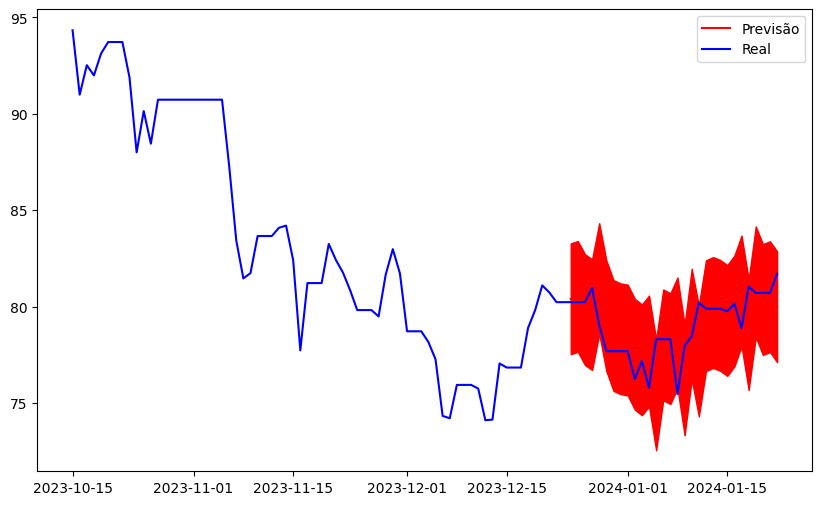

In [98]:
plt.figure(figsize=(10,6))
plt.plot(datas_pred,predicao_media.values, color="red", label="Previsão")
plt.fill_between(datas_pred, lim_abaixo, lim_acima, color="red")
plt.plot(datas[-100:],dados_resample[-100:].values, color="blue", label="Real")
plt.legend()
plt.show()

In [101]:
mae_sarimax = mean_absolute_error(dados_resample[-30:].values, predicao_media.values)
mse_sarimax = mean_squared_error(dados_resample[-30:].values, predicao_media.values)
rmse_sarimax = math.sqrt(mse_sarimax)
mape_sarimax = mean_absolute_percentage_error(dados_resample[-30:].values, predicao_media.values)
wmape_sarimax = wmape(dados_resample[-30:].values, predicao_media.values)
print(f"MAE: {mae_sarimax:.5f}")
print(f"MSE: {mse_sarimax:.5f}")
print(f"RMSE: {rmse_sarimax:.5f}")
print(f"MAPE: {mape_sarimax:.2%}")
print(f"WMAPE: {wmape_sarimax:.2%}")

MAE: 1.10265
MSE: 2.11869
RMSE: 1.45557
MAPE: 1.40%
WMAPE: 65.70%


#### Forecast com SARIMAX

In [106]:
forecast_sarimax = resultado_sarimax.get_forecast(steps=30)
forecast_medio = forecast_sarimax.predicted_mean

In [126]:
pd.DataFrame(forecast_sarimax.predicted_mean.head()).rename(columns={"predicted_mean":"Petróleo Brent (U$)"})


,Petróleo Brent (U$)
2024-01-23,81.632011
2024-01-24,81.465427
2024-01-25,82.177668
2024-01-26,83.087158
2024-01-27,82.973266


In [107]:
intervalo_confianca_forecast = forecast_sarimax.conf_int()
lim_abaixo_f = intervalo_confianca_forecast.iloc[:,0]
lim_acima_f = intervalo_confianca_forecast.iloc[:,1]

lim_abaixo_f[0], lim_acima_f[0]

(78.75967030628945, 84.50435208637657)

In [109]:
forecast_medio[0]

81.63201119633301

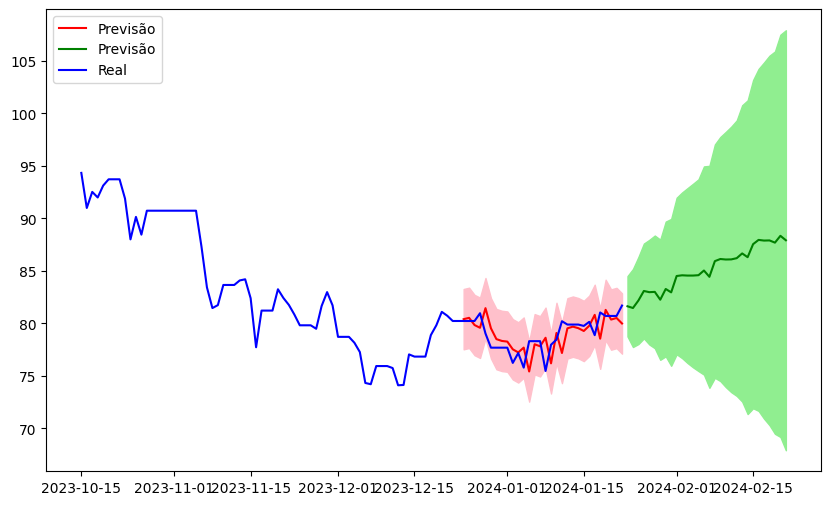

In [111]:
datas_forecast = np.asarray(forecast_medio.index)
datas = np.asarray(dados_resample.index)

plt.figure(figsize=(10,6))

plt.plot(datas_pred,predicao_media.values, color="red", label="Previsão")
plt.fill_between(datas_pred, lim_abaixo, lim_acima, color="pink")

plt.plot(datas_forecast,forecast_medio.values, color="green", label="Previsão")
plt.fill_between(datas_forecast, lim_abaixo_f, lim_acima_f, color="lightgreen")

plt.plot(datas[-100:],dados_resample[-100:].values, color="blue", label="Real")
plt.legend(loc='upper left')
plt.show()

In [128]:
import joblib
joblib.dump(model_sarimax, 'modelo/sarimax.joblib', compress=3)

['modelo/sarimax.joblib']

### Prophet

In [7]:
from prophet import Prophet
from prophet.plot import plot_plotly

c:\Users\Afonso\Documents\GitHub\tech-challenge-g51-fase04\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [8]:
periodo = 7

df_train = dados[['Data','Preço - petróleo bruto - Brent (FOB)']]
df_train = df_train.rename(columns={"Data": "ds", "Preço - petróleo bruto - Brent (FOB)": "y"})

m = Prophet()
m.fit(df_train)
future = m.make_future_dataframe(periods=periodo, freq="B")
forecast = m.predict(future)

18:59:03 - cmdstanpy - INFO - Chain [1] start processing
18:59:12 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
11094,2024-01-25,89.441471,74.604463,99.944270,89.441471,89.441471,-2.452046,-2.452046,-2.452046,-0.047567,-0.047567,-0.047567,-2.404479,-2.404479,-2.404479,0.0,0.0,0.0,86.989425
11095,2024-01-26,89.457084,74.141425,99.013414,89.457084,89.457084,-2.435612,-2.435612,-2.435612,-0.027852,-0.027852,-0.027852,-2.407760,-2.407760,-2.407760,0.0,0.0,0.0,87.021471
11096,2024-01-29,89.503921,74.460826,99.471699,89.503921,89.503921,-2.431438,-2.431438,-2.431438,-0.013958,-0.013958,-0.013958,-2.417481,-2.417481,-2.417481,0.0,0.0,0.0,87.072483
11097,2024-01-30,89.519534,74.468046,99.109684,89.519534,89.519534,-2.505655,-2.505655,-2.505655,-0.087972,-0.087972,-0.087972,-2.417683,-2.417683,-2.417683,0.0,0.0,0.0,87.013879
11098,2024-01-31,89.535146,74.970614,100.102048,89.535146,89.535146,-2.548497,-2.548497,-2.548497,-0.133727,-0.133727,-0.133727,-2.414770,-2.414770,-2.414770,0.0,0.0,0.0,86.986649


In [10]:
plot_plotly(m, forecast)

In [11]:
import joblib
joblib.dump(m, 'modelo/prophet.joblib')

['modelo/prophet.joblib']

### Modelo 1